# Hlasování

In [1]:
if 'google.colab' in str(get_ipython()):
        import os, sys
        print('Nastavení prostředí Google Colab.')
        ! git clone "https://git@github.com/jarbes/snemovna.git --branch master"
        sys.path.insert(0,'snemovna')
        os.chdir('snemovna')

In [2]:
! pip install -r requirements.txt

You should consider upgrading via the '/home/borjana/.venv/finance/bin/python3.7 -m pip install --upgrade pip' command.


In [3]:
from datetime import datetime
import plotly.express as px
import pandas as pd

In [4]:
from snemovna.Hlasovani import Hlasovani, HlasovaniPoslance
from snemovna.PoslanciOsoby import Poslanci, Organy
from nastav_jupyter_notebook import nastav_pandas

In [5]:
nastav_pandas()

In [6]:
hp = HlasovaniPoslance()

2021-03-10:18:56:58 INFO     [utility.py:21] Stahuji 'https://www.psp.cz/eknih/cdrom/opendata/poslanci.zip'.
2021-03-10:18:56:59 WARNING  [Snemovna.py:145] While merging 'funkce' with 'typ_funkce': Dropping ['typ_id_typ_organ__typ_funkce', 'nazev_typ_organ_en__typ_funkce', 'id_typ_organ__typ_funkce', 'nazev_typ_organ_cz__typ_funkce', 'typ_organ_obecny__typ_funkce'] because of abundance.
2021-03-10:18:56:59 WARNING  [utility.py:172] Skipped 1 values while formatting 'do_o' to datetime. Using format '%Y-%m-%d %H'. Example of skipped rows: ['0205-06-09 00'].
2021-03-10:18:57:00 INFO     [utility.py:21] Stahuji 'https://www.psp.cz/eknih/cdrom/opendata/hl-2017ps.zip'.


In [7]:
%%time

df = hp[~hp.je_zmatecne]
data = df[['id_osoba', 'id_hlasovani', 'vysledek', 'zkratka']]\
    .set_index('id_osoba')\
    .sort_values(by=['zkratka'])[['id_hlasovani', 'vysledek']]\
    .groupby('id_osoba', sort=False)\
    .apply(lambda g: list(map(tuple, g.values))).to_dict()

data = {osoba: [str(hl_idx) + '_' + vysledek for hl_idx, vysledek in data[osoba]] for osoba in data.keys()}

CPU times: user 6.02 s, sys: 148 ms, total: 6.17 s
Wall time: 6.18 s


In [8]:
%%time

def jaccard_similarity(list1, list2):
    intersection = len(list(set(list1).intersection(list2)))
    union = (len(list1) + len(list2)) - intersection
    return float(intersection) / union

m = {}
for osoba1, v1 in data.items():
    if osoba1 not in m:
        m[osoba1] = {}
    for osoba2, v2 in data.items():
        m[osoba1][osoba2] = jaccard_similarity(v1, v2)

CPU times: user 46.5 s, sys: 16 ms, total: 46.5 s
Wall time: 46.5 s


In [9]:
korelace_df = pd.DataFrame(m)
osoby = {id_osoba: hp[hp.id_osoba == id_osoba][['jmeno', 'prijmeni', 'zkratka_kandidatka','nazev_kraj_cz', 'zkratka_klub']].iloc[0] for id_osoba in korelace_df}
jmeno_prijmeni = [f"{osoby[id_osoba]['jmeno']} {osoby[id_osoba]['prijmeni']}" for id_osoba in korelace_df.index]
zkratka_klub = [osoby[id_osoba]['zkratka_klub'] for id_osoba in korelace_df.index]
label = [f"{j} ({zk})" for j, zk in zip(jmeno_prijmeni, zkratka_klub)]

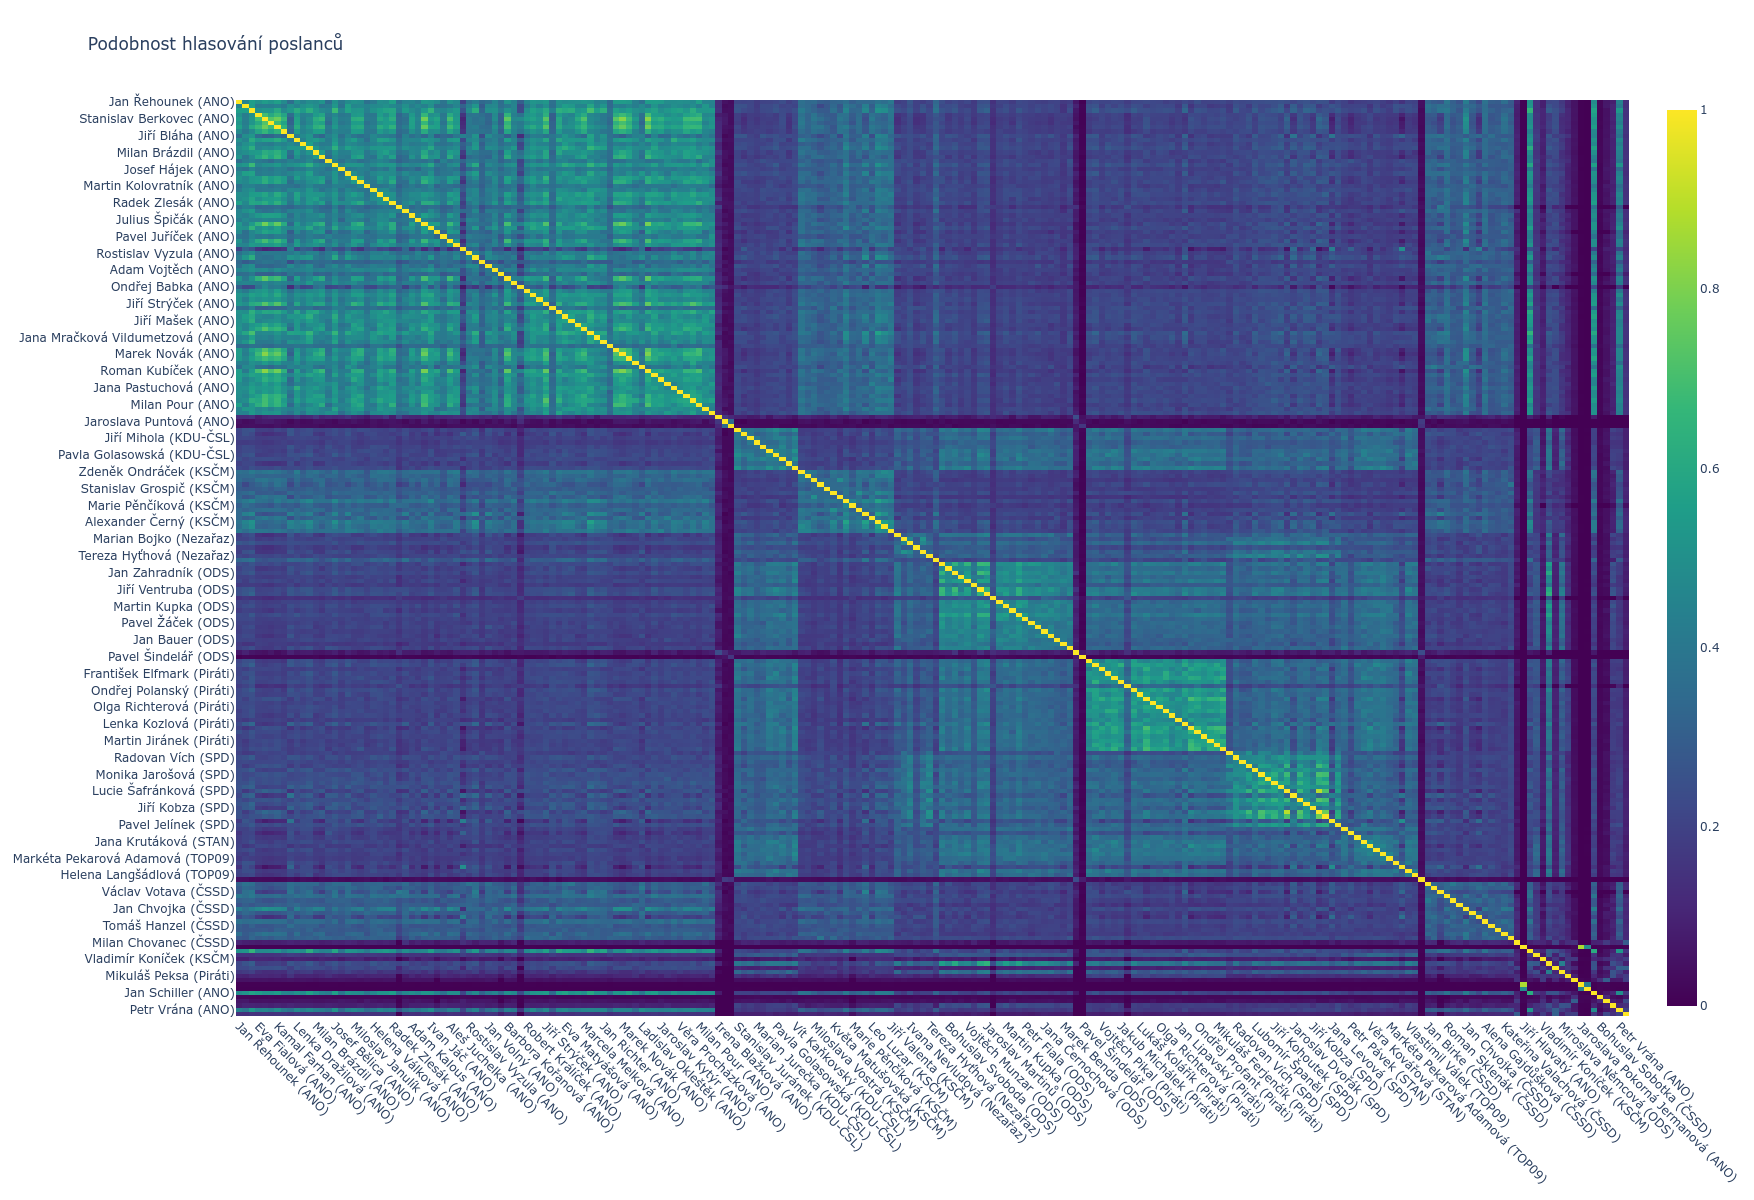

In [10]:
import plotly.graph_objects as go
fig = go.Figure(data=go.Heatmap(
        z=korelace_df,
        x=label,
        y=label,
        colorscale='Viridis',
        hovertemplate="%{x}<br>%{y}<br>Podobnost hlasování: %{z}<extra></extra>"
))

fig.update_layout(title='Podobnost hlasování poslanců',  width=1200, height=1200)
fig.update_xaxes(type='category', tickangle=45)
fig.update_yaxes(type='category', autorange='reversed')
fig.show()

In [11]:
print(f"Poslední běh notebooku: {datetime.now().strftime('%d.%m.%Y %H:%M:%S')}.")

Poslední běh notebooku: 10.03.2021 18:58:16.
